<a href="https://colab.research.google.com/github/kxtubh/LungCancerPrediction/blob/main/rf_lungcaner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Import all dependencies and dataset

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle


In [ ]:
!mv kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json # Sets proper file permissions

In [ ]:
!kaggle datasets download -d adityamahimkar/iqothnccd-lung-cancer-dataset

Dataset URL: https://www.kaggle.com/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset
License(s): copyright-authors


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from itertools import cycle


In [ ]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

<ipython-input-8-c75c8f701b44>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


#2. Image preprocessing

In [ ]:
file_name = "/content/iqothnccd-lung-cancer-dataset.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
 os.chdir('/content/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases')
images = []
labels = []

for i in tqdm(os.listdir()):
      img = cv2.imread(i)
      img = cv2.resize(img,(224,224))
      images.append(img)
      labels.append((i[0:1]))


  0%|          | 0/120 [00:00<?, ?it/s]

In [ ]:
os.chdir('/content/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Malignant cases')
for i in tqdm(os.listdir()):
      img = cv2.imread(i)
      img = cv2.resize(img,(224,224))
      images.append(img)
      labels.append((i[0:1]))

  0%|          | 0/561 [00:00<?, ?it/s]

In [ ]:
os.chdir('/content/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases')
for i in tqdm(os.listdir()):
      img = cv2.imread(i)
      img = cv2.resize(img,(224,224))
      images.append(img)
      labels.append((i[0:1]))

  0%|          | 0/416 [00:00<?, ?it/s]

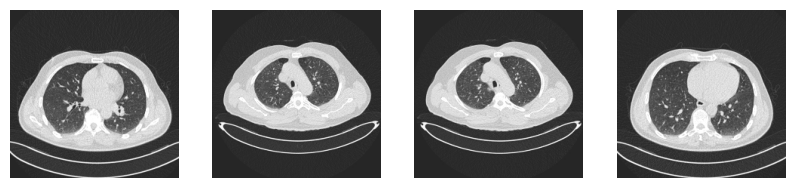

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i], cmap="gray")
    plt.axis('off')
plt.show()

#3.Spliting the dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.33, random_state=42)
print ("Shape of an image in X_train: ", X_train[0].shape)
print ("Shape of an image in X_test: ", X_test[0].shape)

Shape of an image in X_train:  (224, 224, 3)
Shape of an image in X_test:  (224, 224, 3)


In [ ]:
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [ ]:
class_names = le.classes_
print(f"Classes: {class_names}")

Classes: ['B' 'M' 'N']


In [ ]:
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=3)

In [ ]:
y_train_cat = np.array(y_train_cat)
X_train = np.array(X_train)
y_test_cat = np.array(y_test_cat)
X_test = np.array(X_test)

In [ ]:
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train_cat.shape)
print("y_test Shape: ", y_test_cat.shape)

X_train Shape:  (734, 224, 224, 3)
X_test Shape:  (363, 224, 224, 3)
y_train Shape:  (734, 3)
y_test Shape:  (363, 3)


In [ ]:
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

In [ ]:
print("Flattened X_train Shape: ", X_train_flattened.shape)
print("Flattened X_test Shape: ", X_test_flattened.shape)

Flattened X_train Shape:  (734, 150528)
Flattened X_test Shape:  (363, 150528)


#4. Model Design

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    max_depth=20,      # Maximum depth of trees
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,         # Use all available cores
    class_weight='balanced'  # Handle class imbalance
)

#5. Model Training

In [ ]:
# Train the model
print("Training Random Forest model...")
rf_model.fit(X_train_flattened, y_train)
print("Training complete!")

Training Random Forest model...
Training complete!


In [ ]:
y_pred = rf_model.predict(X_test_flattened)

#6. Evaluation



#7. Prediction

In [ ]:
import seaborn as sns

In [ ]:
# Modified prediction function to include confidence and precision values
def predict_image_rf(image_path, model, y_test=None, y_pred=None):
    try:
        img = cv2.imread(image_path)
        if img is None:
            return "Error: Could not load image."

        img = cv2.resize(img, (224, 224))

        # Flatten the image
        img_flattened = img.reshape(1, -1)

        # Make the prediction
        prediction = model.predict_proba(img_flattened)
        predicted_class_index = model.predict(img_flattened)[0]

        # Map the index to a class name
        class_names = ['Benign', 'Malignant', 'Normal']  # Based on your dataset classes
        predicted_class = class_names[predicted_class_index]

        # Get confidence (probability) for the predicted class
        confidence = prediction[0][predicted_class_index]

        # Calculate precision for this class (if test data is available)
        precision = "N/A"
        if y_test is not None and y_pred is not None:
            from sklearn.metrics import precision_score
            class_precision = precision_score(y_test, y_pred, labels=[predicted_class_index], average=None)
            precision = class_precision[0] if len(class_precision) > 0 else "N/A"

        # Get probabilities for all classes
        class_probabilities = {class_names[i]: f"{prediction[0][i]:.4f}" for i in range(len(class_names))}

        # Create a visualization of the prediction
        plt.figure(figsize=(12, 5))

        # Show the image
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Input Image")
        plt.axis('off')

        # Show the probabilities
        plt.subplot(1, 2, 2)
        colors = ['green' if i == predicted_class_index else 'gray' for i in range(len(class_names))]
        sns.barplot(x=list(map(float, class_probabilities.values())), y=list(class_probabilities.keys()), palette=colors)
        plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence:.4f}, Precision: {precision}")
        plt.xlim(0, 1)
        plt.tight_layout()
        plt.show()

        return f"Predicted class: {predicted_class} with confidence {confidence:.4f} and class precision {precision}"

    except Exception as e:
        return f"Error during prediction: {e}"


In [ ]:
def predict_image_rf(image_path, model, y_test=None, y_pred=None):
    try:
        img = cv2.imread(image_path)
        if img is None:
            return "Error: Could not load image."

        img = cv2.resize(img, (224, 224))

        # Flatten the image
        img_flattened = img.reshape(1, -1)

        # Make the prediction
        prediction = model.predict_proba(img_flattened)
        predicted_class_index = model.predict(img_flattened)[0]

        # Map the index to a class name
        class_names = ['Benign', 'Malignant', 'Normal']  # Based on your dataset classes
        predicted_class = class_names[predicted_class_index]

        # Get confidence (probability) for the predicted class
        confidence = prediction[0][predicted_class_index]

        # Calculate precision for this class (if test data is available)
        precision = "N/A"
        if y_test is not None and y_pred is not None:
            from sklearn.metrics import precision_score
            class_precision = precision_score(y_test, y_pred, labels=[predicted_class_index], average=None)
            precision = class_precision[0] if len(class_precision) > 0 else "N/A"

        # Get probabilities for all classes
        class_probabilities = {class_names[i]: f"{prediction[0][i]:.4f}" for i in range(len(class_names))}

        # Create a visualization of the prediction
        plt.figure(figsize=(12, 5))

        # Show the image
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Input Image")
        plt.axis('off')

        # Show the probabilities
        plt.subplot(1, 2, 2)
        colors = ['green' if i == predicted_class_index else 'gray' for i in range(len(class_names))]
        sns.barplot(x=list(class_probabilities.keys()),y=list(map(float, class_probabilities.values())), palette=colors)
        plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence:.4f}, Precision: {precision}")
        plt.xlim(0, 1)
        plt.tight_layout()
        plt.show()

        return f"Predicted class: {predicted_class} with confidence {confidence:.4f} and class precision {precision}"

    except Exception as e:
        return f"Error during prediction: {e}"

<ipython-input-28-073da0f9e92d>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_probabilities.keys()),y=list(map(float, class_probabilities.values())), palette=colors)


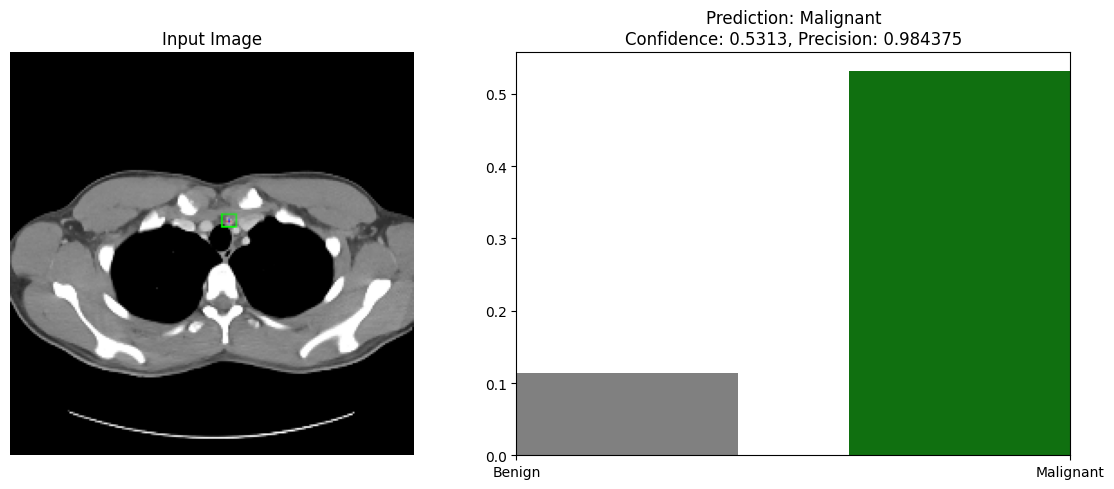

Predicted class: Malignant with confidence 0.5313 and class precision 0.984375


In [ ]:
# # For individual image prediction with confidence and precision:
result = predict_image_rf("/content/Test cases/000021_03_01_012.png", rf_model, y_test, y_pred)
print(result)

#8. Visualization

In [ ]:
def plot_roc_curves(y_test, y_pred_proba, class_names):
    """
    Plot ROC curves for each class.

    Parameters:
    - y_test: One-hot encoded test labels
    - y_pred_proba: Predicted probabilities
    - class_names: List of class names
    """
    plt.figure(figsize=(12, 8))

    # Calculate and plot ROC curve for each class
    for i, class_name in enumerate(class_names):
        # Convert to binary one-vs-rest classification
        y_true_binary = (np.array(y_test) == i).astype(int)

        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_true_binary, y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.4f})')

    # Plot the random guessing line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Each Class')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [ ]:

def plot_precision_recall_curves(y_test, y_pred_proba, class_names):
    """
    Plot precision-recall curves for each class.

    Parameters:
    - y_test: Test labels
    - y_pred_proba: Predicted probabilities
    - class_names: List of class names
    """
    plt.figure(figsize=(12, 8))

    # Plot precision-recall curve for each class
    for i, class_name in enumerate(class_names):
        # Convert to binary one-vs-rest classification
        y_true_binary = (np.array(y_test) == i).astype(int)

        # Calculate precision-recall curve
        precision, recall, _ = precision_recall_curve(y_true_binary, y_pred_proba[:, i])
        pr_auc = auc(recall, precision)

        # Plot precision-recall curve
        plt.plot(recall, precision, lw=2, label=f'{class_name} (AUC = {pr_auc:.4f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for Each Class')
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()


In [ ]:

def plot_classification_metrics(y_test, y_pred, class_names):
    """
    Plot bar charts for precision, recall, and F1-score for each class.

    Parameters:
    - y_test: Test labels
    - y_pred: Predicted labels
    - class_names: List of class names
    """
    from sklearn.metrics import precision_recall_fscore_support

    # Calculate precision, recall, and F1-score for each class
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, labels=range(len(class_names)))

    # Create a dataframe for easier plotting
    import pandas as pd
    metrics_df = pd.DataFrame({
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }, index=class_names)

    # Plot the metrics
    plt.figure(figsize=(14, 10))

    # Plot each metric
    metrics_df.plot(kind='bar', ax=plt.gca())
    plt.title('Classification Metrics by Class')
    plt.ylabel('Score')
    plt.xlabel('Class')
    plt.xticks(rotation=45)
    plt.ylim(0, 1.0)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.grid(True, axis='y')
    plt.show()


In [ ]:


def plot_confusion_matrix(y_test, y_pred, class_names):
    """
    Plot an enhanced confusion matrix with percentages and counts.

    Parameters:
    - y_test: Test labels
    - y_pred: Predicted labels
    - class_names: List of class names
    """
    from sklearn.metrics import confusion_matrix

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(10, 8))

    # Create a custom annotation for both count and percentage
    annot = np.empty_like(cm, dtype=object)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)"

    # Plot the confusion matrix
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Count and Percentage)')
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_loss_curves(model, X_train, y_train, X_test, y_test):
    """
    Plot learning curves showing training and validation loss.

    Parameters:
    - model: Trained model
    - X_train: Training features
    - y_train: Training labels
    - X_test: Test features
    - y_test: Test labels
    """
    from sklearn.model_selection import learning_curve

    # Reshape X_train and X_test to 2D before passing to learning_curve
    X_train_flattened = X_train.reshape(X_train.shape[0], -1)
    X_test_flattened = X_test.reshape(X_test.shape[0], -1)

    # Calculate learning curves using the flattened data
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train_flattened, y_train,  # Use flattened data
        cv=5,
        scoring='neg_log_loss',
        train_sizes=np.linspace(0.1, 1.0, 10),
        random_state=42
    )

     # Calculate mean and std of training scores and test scores
    train_mean = -np.mean(train_scores, axis=1)  # Negative because neg_log_loss
    train_std = np.std(train_scores, axis=1)
    test_mean = -np.mean(test_scores, axis=1)  # Negative because neg_log_loss
    test_std = np.std(test_scores, axis=1)

    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training Loss')
    plt.plot(train_sizes, test_mean, 'o-', color='g', label='Validation Loss')

    # Add error bars
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')

    plt.title('Learning Curves (Loss)')
    plt.xlabel('Training Examples')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [ ]:
 #Example usage of the visualization functions
def visualize_model_performance(rf_model, X_train, y_train, X_test, y_test, X_test_flattened):
    """
    Comprehensive visualization of model performance.

    Parameters:
    - rf_model: Trained Random Forest model
    - X_train, y_train: Training data
    - X_test, y_test: Test data
    - X_test_flattened: Flattened test data
    """
    # Generate predictions
    y_pred = rf_model.predict(X_test_flattened)
    y_pred_proba = rf_model.predict_proba(X_test_flattened)

    # Define class names
    class_names = ['Benign', 'Malignant', 'Normal']

    # Plot all visualizations
    print("Plotting ROC Curves...")
    plot_roc_curves(y_test, y_pred_proba, class_names)

    print("Plotting Precision-Recall Curves...")
    plot_precision_recall_curves(y_test, y_pred_proba, class_names)

    print("Plotting Classification Metrics...")
    plot_classification_metrics(y_test, y_pred, class_names)

    print("Plotting Confusion Matrix...")
    plot_confusion_matrix(y_test, y_pred, class_names)

    print("Plotting Loss Curves...")
    plot_loss_curves(rf_model, X_train, y_train, X_test, y_test)

    return y_pred,y_pred_proba


Plotting ROC Curves...


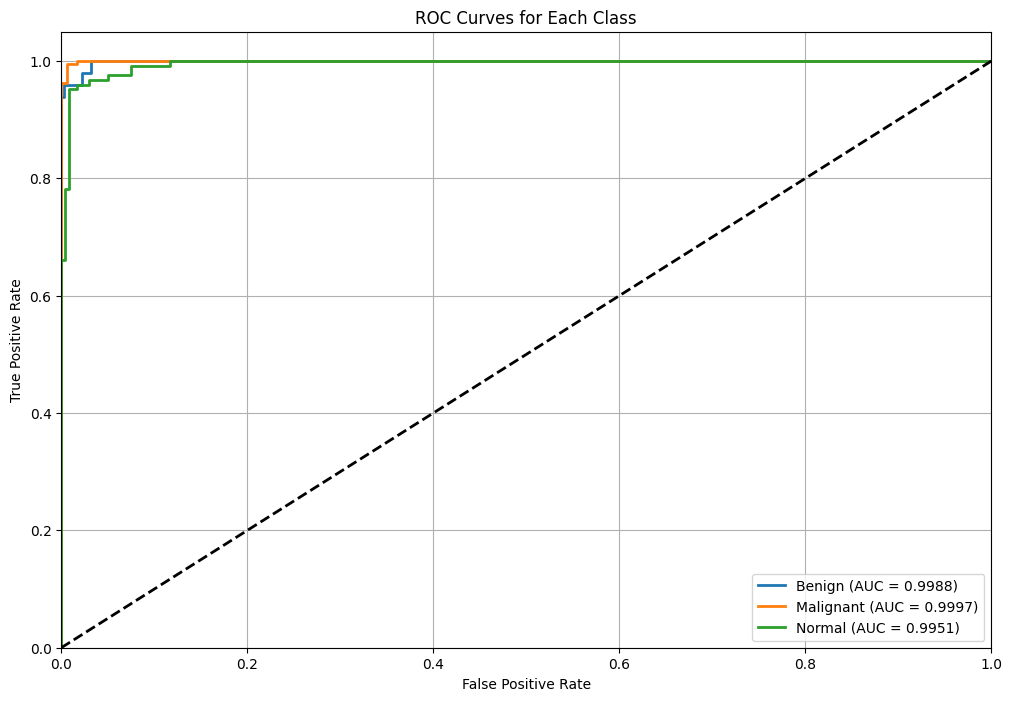

Plotting Precision-Recall Curves...


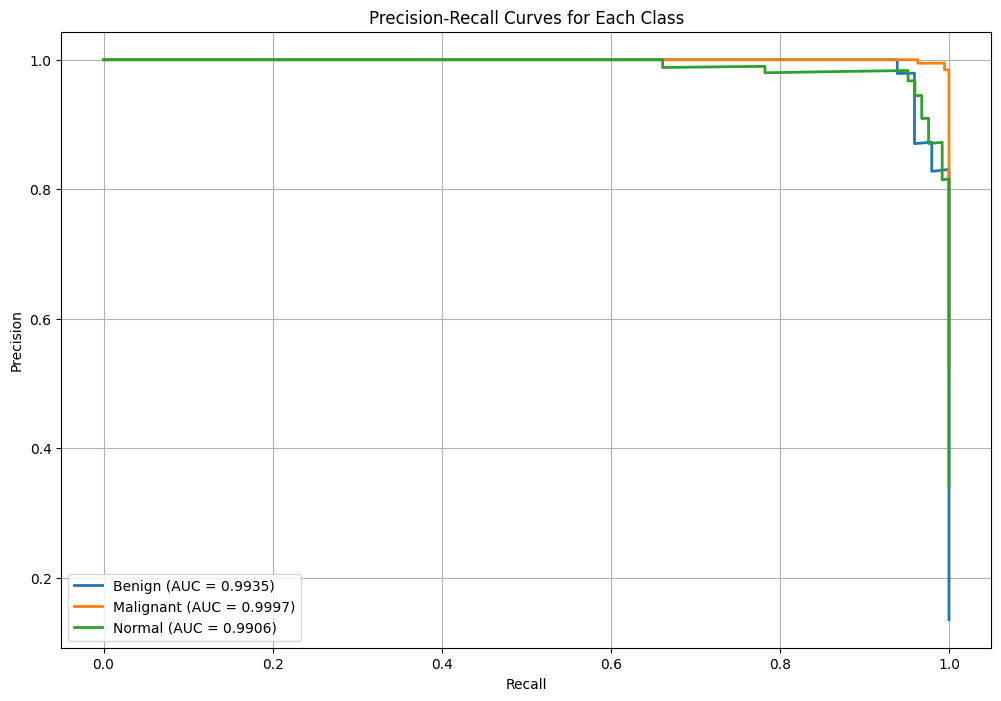

Plotting Classification Metrics...


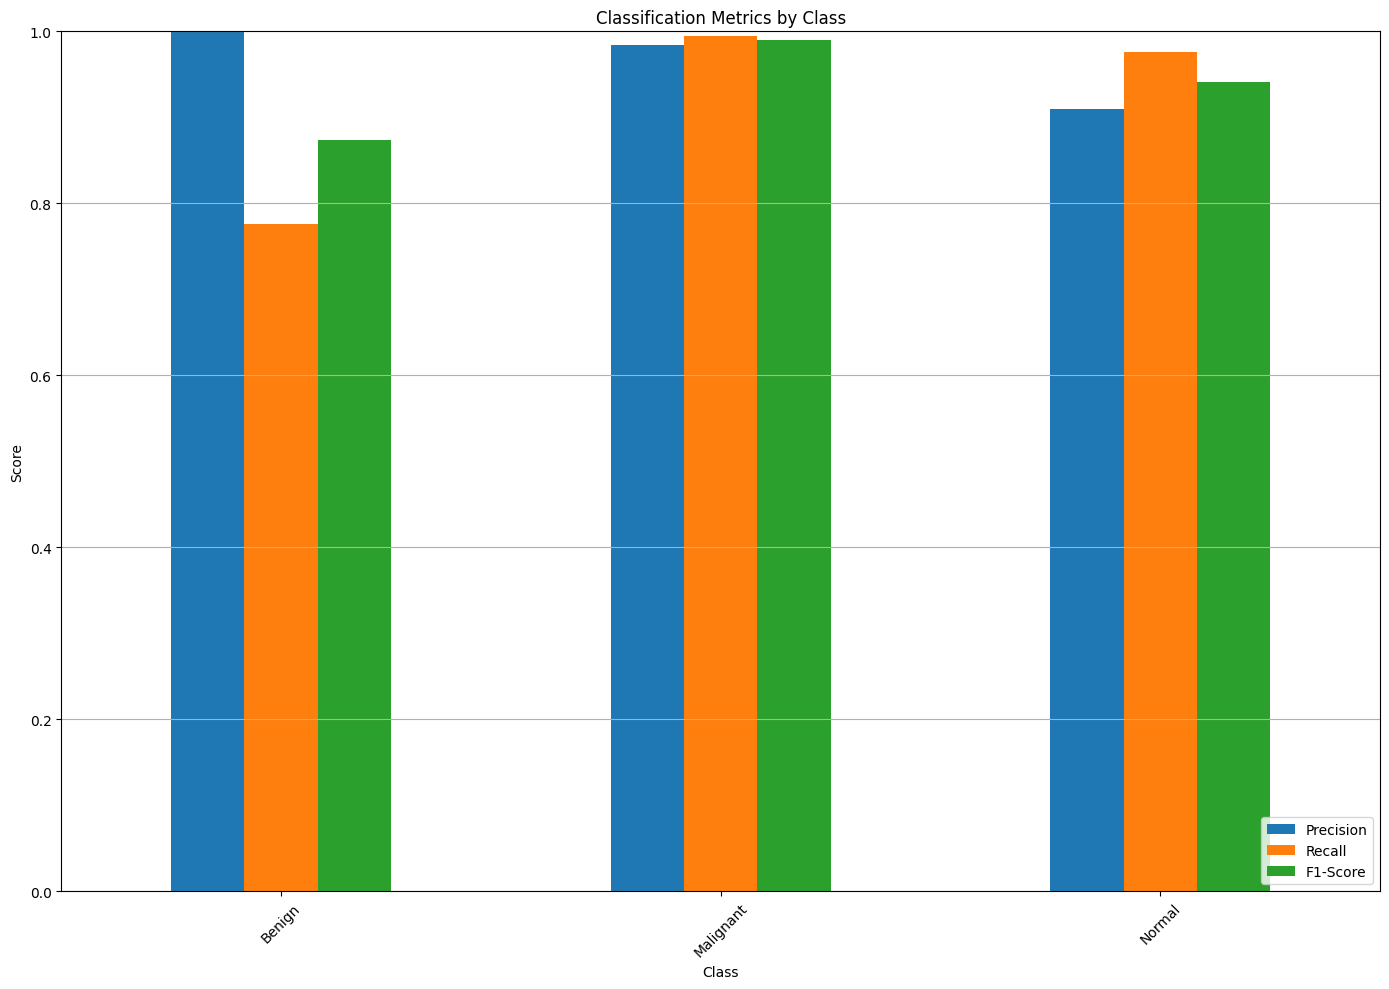

Plotting Confusion Matrix...


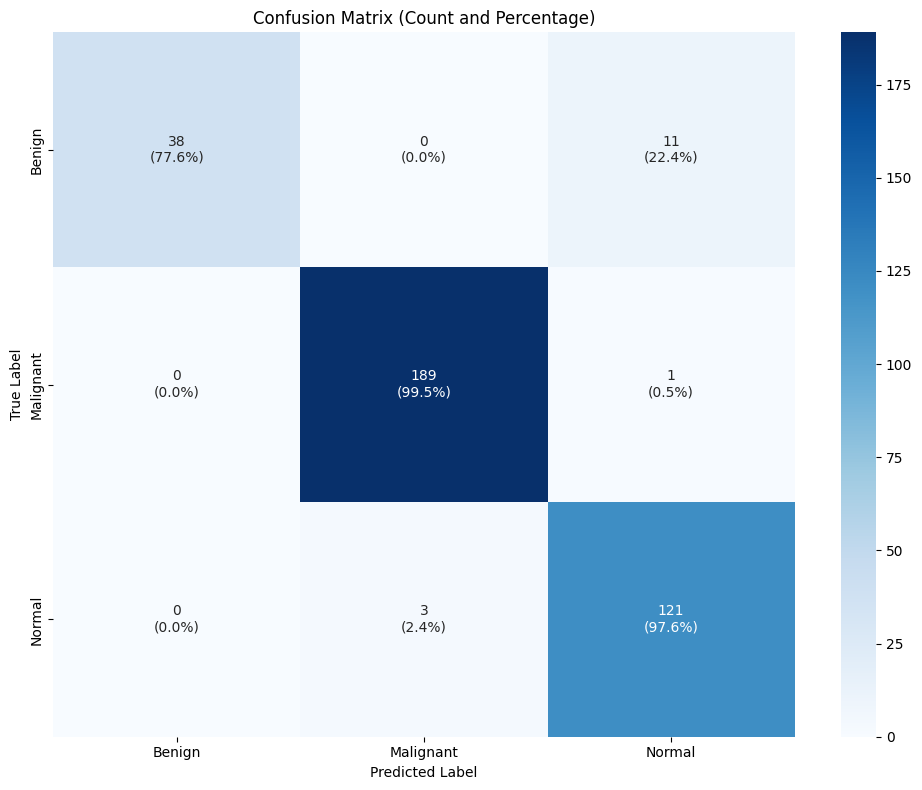

Plotting Loss Curves...


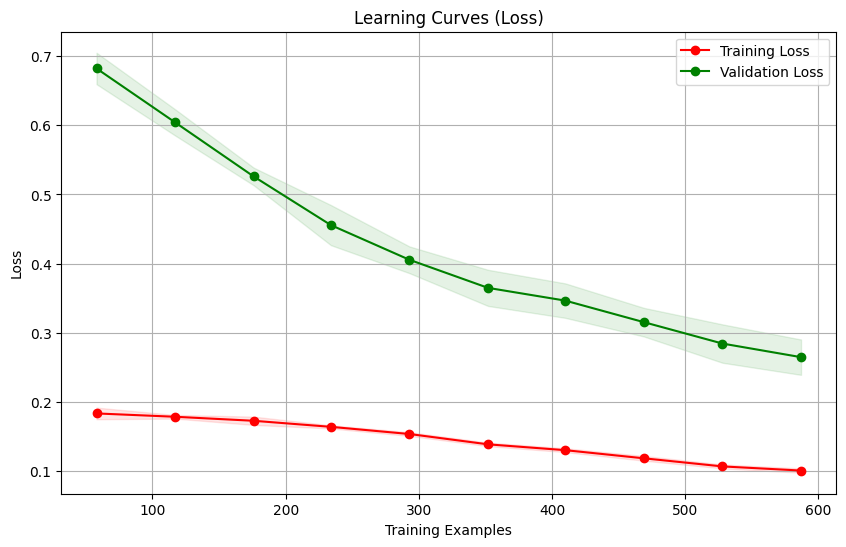

In [ ]:
# After training the model, you can use these functions as follows:
y_pred, y_pred_proba = visualize_model_performance(rf_model, X_train, y_train, y_test, y_test, X_test_flattened) # Added X_test_flattened to the function call

In [ ]:
 # Calculate and print overall metrics
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))



Test Accuracy: 0.9587

Classification Report:
              precision    recall  f1-score   support

           B       1.00      0.78      0.87        49
           M       0.98      0.99      0.99       190
           N       0.91      0.98      0.94       124

    accuracy                           0.96       363
   macro avg       0.96      0.92      0.93       363
weighted avg       0.96      0.96      0.96       363

